# Prediction
This notebook consists of two parts:
1. Exploring the possibilities of fusing the sensors into one signal (health indicator).
2. Applying cross-validation and making our final prediction.

<br><br><br><br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import pickle

sns.set(style='whitegrid')
sys.path.append('..')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=RuntimeWarning)

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression, LogisticRegression
from load_data import *

from numpy.random import default_rng
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

<br><br><br><br><br><br>
# 1. Exploration

In [14]:
df = load_dataset('../data/DataTrain.txt')
df = df.set_index('engine_id')

df = df[['cycle', 's11', 's4', 's12', 's7', 's15', 's21', 's20', 's17', 's2', 's3', 's13', 's8']]

In [15]:
def get_ruls(dataframe):
    """
    Get the ruls of the engines
    """
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = (dataframe['max_cycle'] - dataframe['cycle'] + 1).values
    
    return ruls

df.loc[:, 'rul'] = get_ruls(df)

df[['cycle', 'rul']].tail()

,cycle,rul
engine_id,,
100,196,5
100,197,4
100,198,3
100,199,2
100,200,1


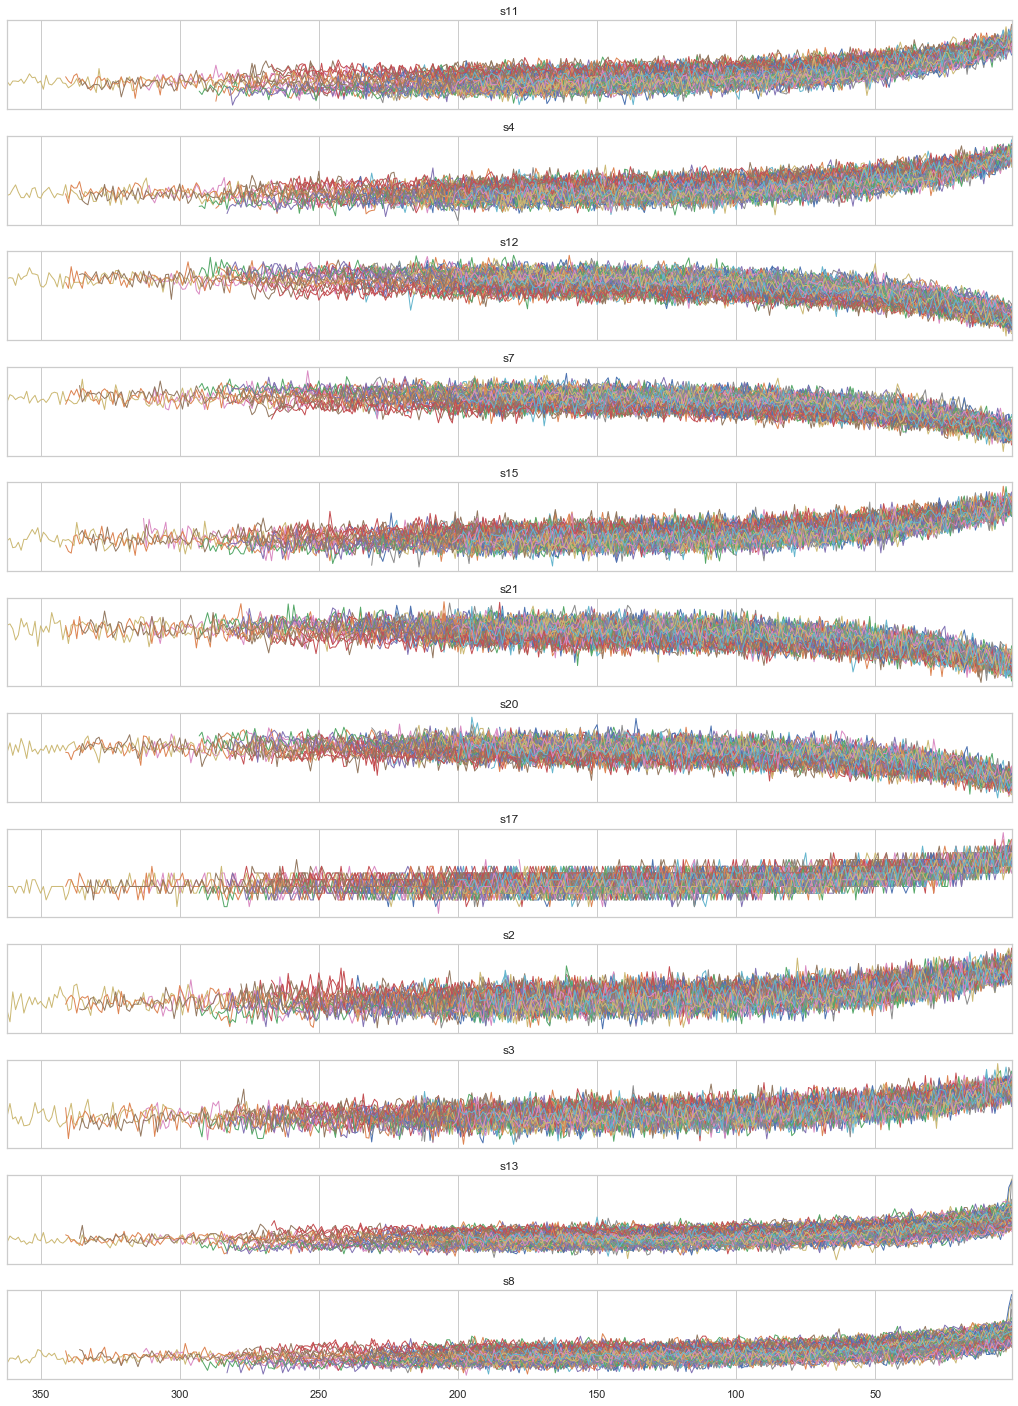

In [16]:
def plot_timeseries(dataframe):
    ts = dataframe.copy()
    
    max_rul = ts['rul'].max()
    
    ts.drop(labels=['cycle'], axis=1, inplace=True)

    cols = ts.columns
    fig, axes = plt.subplots(len(cols)-1, 1, figsize=(18,25), sharex=True)

    for col, ax in zip(cols, axes):
        if col == 'rul':
            continue

        ax.set_title(col, fontdict={'fontsize': 12})
        ax.set_xlim(max_rul, 1)
        ax.get_yaxis().set_visible(False)

        for engine_id in ts.index.unique():
            time = ts.loc[engine_id, 'rul']
            ax.plot(time, ts.loc[engine_id,col], label=col, linewidth=1)

    plt.subplots_adjust(hspace=0.3)
    
plot_timeseries(df)

In [17]:
df_norm = df.copy()

scaler = StandardScaler()

df_norm.iloc[:, 1:-1] = scaler.fit_transform(df.iloc[:, 1:-1])

df_norm.head()

,cycle,s11,s4,s12,s7,s15,s21,s20,s17,s2,s3,s13,s8,rul
engine_id,,,,,,,,,,,,,,
1,1,-0.266467,-0.925936,0.334262,1.121141,-0.603816,1.194427,1.348493,-0.781710,-1.721725,-0.134255,-1.058890,-0.516338,192
1,2,-0.191583,-0.643726,1.174899,0.431930,-0.275852,1.236922,1.016528,-0.781710,-1.061780,0.211528,-0.363646,-0.798093,191
1,3,-1.015303,-0.525953,1.364721,1.008155,-0.649144,0.503423,0.739891,-2.073094,-0.661813,-0.413166,-0.919841,-0.234584,190
1,4,-1.539489,-0.784831,1.961302,1.222827,-1.971665,0.777792,0.352598,-0.781710,-0.661813,-1.261314,-0.224597,0.188048,189
1,5,-0.977861,-0.301518,1.052871,0.714393,-0.339845,1.059552,0.463253,-0.136018,-0.621816,-1.251528,-0.780793,-0.516338,188


### Linear regression on the slopes
The engine to use for testing

In [18]:
ENGINE_ID = 87

#### The sensor columns

In [19]:
sensor_cols = df.columns[1:-1].tolist()
sensor_cols

['s11', 's4', 's12', 's7', 's15', 's21', 's20', 's17', 's2', 's3', 's13', 's8']

#### The X data is the RUL

In [20]:
X = df_norm.loc[ENGINE_ID, 'rul'].values
X = X.reshape(-1, 1)
X[:5,:]

array([[178],
       [177],
       [176],
       [175],
       [174]], dtype=int64)

#### The Y data are the sensor values

In [21]:
y = df_norm.loc[ENGINE_ID, sensor_cols].values
y[:5, :5]

array([[-0.67832678, -0.52261996,  0.89016727,  1.04205085, -0.09453844],
       [-0.3787921 ,  0.30845545,  0.53764188,  0.61270667,  0.03078109],
       [-0.71576862, -1.10037291,  0.89016727,  1.00815526, -0.46249793],
       [-0.97786146, -1.27147668,  0.75458058, -0.51714643,  0.09744042],
       [-0.71576862, -0.37040427,  0.97151929, -0.13299638, -0.60648207]])

#### Fit the linear models

In [22]:
linear_model = LinearRegression()

In [23]:
linear_model.fit(X, y);

In [24]:
linear_model.coef_

array([[-0.01331739],
       [-0.01368972],
       [ 0.01494337],
       [ 0.01335374],
       [-0.01238661],
       [ 0.01115793],
       [ 0.0125199 ],
       [-0.01095218],
       [-0.01150375],
       [-0.01163501],
       [-0.01681583],
       [-0.01598344]])

#### Run the prediction on the sensor data

In [25]:
y_hat = linear_model.predict(X)
y_hat[:5, :5]

array([[-0.90951149, -0.99246963,  1.08126867,  0.89501037, -0.87162778],
       [-0.8961941 , -0.9787799 ,  1.0663253 ,  0.88165663, -0.85924117],
       [-0.8828767 , -0.96509018,  1.05138193,  0.86830289, -0.84685455],
       [-0.86955931, -0.95140045,  1.03643855,  0.85494914, -0.83446794],
       [-0.85624191, -0.93771073,  1.02149518,  0.8415954 , -0.82208133]])

#### Plot the sensor data and fitted trends

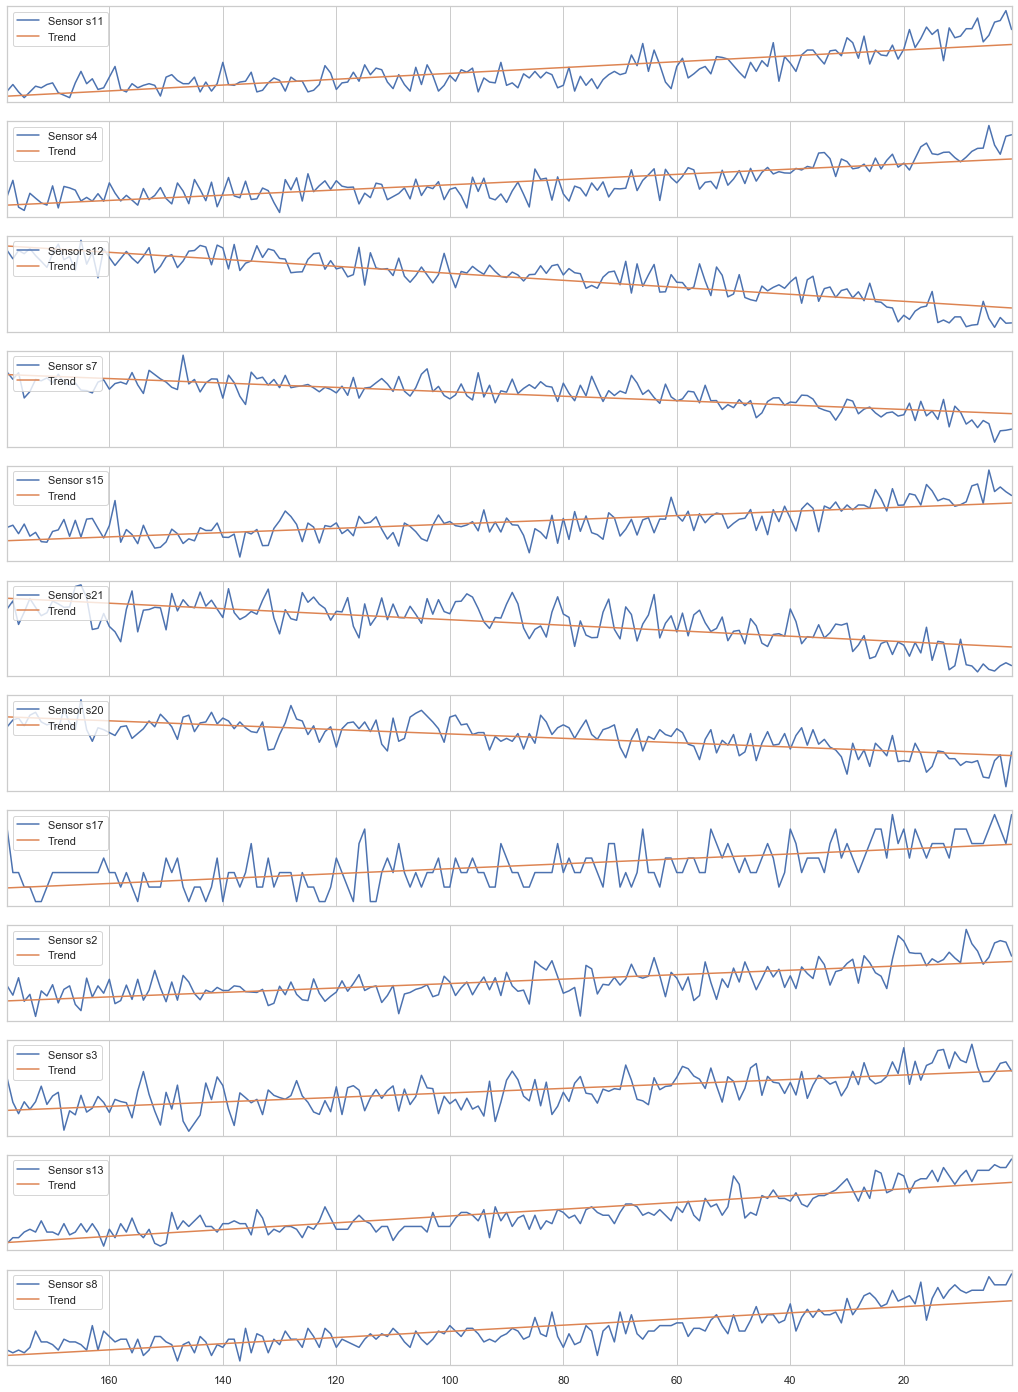

In [26]:
# plotting 
time    = X.flatten()
sensors = y

fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(18, 25), sharex=True)

for col, ax in zip(range(len(sensor_cols)), axes):
    ax.plot()
    
    ax.plot(time, y[:, col], label=f'Sensor {sensor_cols[col]}')
    ax.plot(time, y_hat[:, col], label='Trend')
    
    ax.set_xlim(time[0], 1)
    ax.get_yaxis().set_visible(False)
    ax.legend(loc='upper left')

### Find slopes for all engines

In [27]:
def get_training_data(dataframe, engine_id, sensor_cols):
    # X data
    X = dataframe.loc[engine_id, 'rul'].values
    X = X.reshape(-1, 1)
    
    # y data
    y = dataframe.loc[engine_id, sensor_cols].values
    
    return (X, y)

In [28]:
def slopes_of_engine(X, y):
    """
    Fit a linear model on the sensor values of one engine
    """
    # Create a linear model
    linear_model = LinearRegression()
    
    # Fit the model
    linear_model.fit(X, y)
    
    # Get slopes
    slopes = linear_model.coef_[:,0]
    
    return slopes

#### Example of engine 1

In [32]:
X, y = get_training_data(df_norm, 1, sensor_cols)
slopes_of_engine(X, y)

array([-0.01522525, -0.01411326,  0.01532887,  0.01478159, -0.01185145,
        0.01333733,  0.01213534, -0.01175761, -0.01214621, -0.00986317,
       -0.01603614, -0.01448081])

#### Get slopes of all engines

In [36]:
def slopes_all_engine(dataframe, sensor_cols):
    """
    Get the sensor slopes of all engines
    """
    engine_slopes = {}
    
    for engine_id in dataframe.index.unique():
        X, y = get_training_data(dataframe, engine_id, sensor_cols)
        slopes = slopes_of_engine(X, y)
        
        engine_slopes[engine_id] = slopes
        
    return engine_slopes
        
engine_slopes = slopes_all_engine(df, sensor_cols)

In [37]:
df_engine_slopes = pd.DataFrame(engine_slopes).T

df_engine_slopes.columns = sensor_cols
df_engine_slopes.index.name = 'engine_id'

df_engine_slopes.head()

,s11,s4,s12,s7,s15,s21,s20,s17,s2,s3,s13,s8
engine_id,,,,,,,,,,,,
1,-0.004066,-0.127025,0.011306,0.013083,-0.000444,0.001444,0.002193,-0.018209,-0.006074,-0.060471,-0.001153,-0.001028
2,-0.003025,-0.097428,0.007948,0.009111,-0.000399,0.001078,0.001844,-0.014438,-0.005309,-0.058401,-0.000618,-0.000595
3,-0.003767,-0.131191,0.008516,0.010185,-0.000532,0.001426,0.002293,-0.021229,-0.006066,-0.085967,-0.000375,-0.000402
4,-0.003057,-0.097852,0.006927,0.008839,-0.000422,0.001122,0.001984,-0.019860,-0.004948,-0.066386,-0.000223,-0.000218
5,-0.003089,-0.105127,0.008026,0.009382,-0.000370,0.001119,0.001874,-0.016325,-0.005021,-0.066011,-0.000539,-0.000530


#### Sensor with highest slopes
Sensors with higher slopes make it easier to distinguish the different ruls.

In [38]:
high_trend_sensors = df_engine_slopes.mean(axis=0).abs().sort_values(ascending=False).index.tolist()
high_trend_sensors

['s4', 's3', 's17', 's7', 's12', 's2', 's11', 's20', 's21', 's13', 's8', 's15']

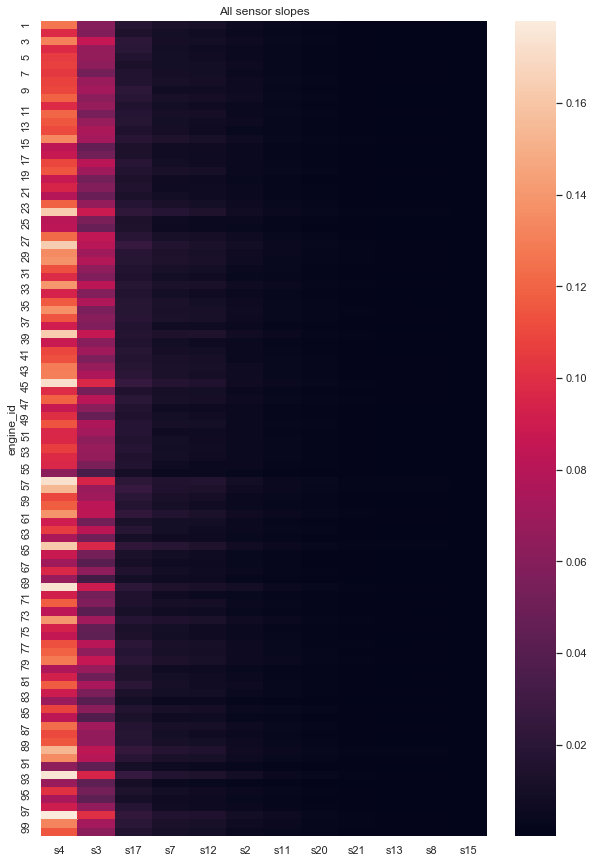

In [39]:
plt.figure(figsize=(10, 15))
sns.heatmap(df_engine_slopes[high_trend_sensors].abs(), cbar=True)
plt.title('All sensor slopes');

### PCA on the sensor slopes

In [42]:
top_n_sensors = 6
n_components  = 3

high_trend = df_norm[high_trend_sensors[:top_n_sensors]]

pca = PCA(n_components=n_components)
pca.fit(high_trend);

#### Variance explained by the different pca components

In [43]:
var_explained = sum((100 * pca.explained_variance_ratio_).tolist())
round(var_explained, 2)

88.35

#### Only select top n sensors

In [44]:
sensors_pca = pca.transform(high_trend)
sensors_pca.shape

(20631, 3)

In [45]:
sensors_pca[:5]

array([[-2.05084746,  0.8367827 , -0.54177219],
       [-1.60776318,  0.92661892, -0.17947421],
       [-2.46695247,  0.67202738,  1.05723803],
       [-2.74294133, -0.36478208, -0.02755966],
       [-1.65870861, -0.71076905, -0.37982505]])

#### Join the pca with the original dataframe

In [46]:
matrix = np.column_stack([df_norm[['cycle', 'rul']].values, sensors_pca])

df_pca = pd.DataFrame(matrix, index=df.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])
df_pca.head()

,cycle,rul,pca1,pca2,pca3
engine_id,,,,,
1,1.0,192.0,-2.050847,0.836783,-0.541772
1,2.0,191.0,-1.607763,0.926619,-0.179474
1,3.0,190.0,-2.466952,0.672027,1.057238
1,4.0,189.0,-2.742941,-0.364782,-0.027560
1,5.0,188.0,-1.658709,-0.710769,-0.379825


### Sensor fusing

In [47]:
high_rul = 250
low_rul  = 5
ruls     = df_pca['rul'].values

In [48]:
idx_high_health = [ruls > high_rul][0]
idx_low_health  = [ruls <= low_rul][0]

In [49]:
# PCA to perform sensor fusing on
high_health_data = df_pca.loc[idx_high_health, ['pca1', 'pca2', 'pca3']]
low_health_data  = df_pca.loc[idx_low_health, ['pca1', 'pca2', 'pca3']]

# concatenate high HI and Low HI data
X_health = np.concatenate((high_health_data, low_health_data),axis=0)

# target for the fused signal [ just 0 or 1 for failed ans healthy]
y_one = np.ones(high_health_data.shape[0])
y_zero = np.zeros(low_health_data.shape[0])

# concatenate high HI and Low HI target
y_health = np.concatenate((y_one, y_zero),axis=0)

In [50]:
X_health[:5]

array([[-3.52539633,  0.28845251, -0.06775611],
       [-3.37230716,  0.67129106, -0.72914571],
       [-3.58956253,  1.18823063, -0.51662177],
       [-3.40366741,  0.41470903, -0.29021931],
       [-3.9161391 , -0.16272027,  0.31247302]])

In [51]:
y_health[:5]

array([1., 1., 1., 1., 1.])

In [52]:
# Linear regression
linear_model = LinearRegression()
linear_model.fit(X_health, y_health)

# Logistic regression
logistic_model = LogisticRegression(solver='liblinear')
logistic_model.fit(X_health, y_health);

#### Predict the health index for a certain engine

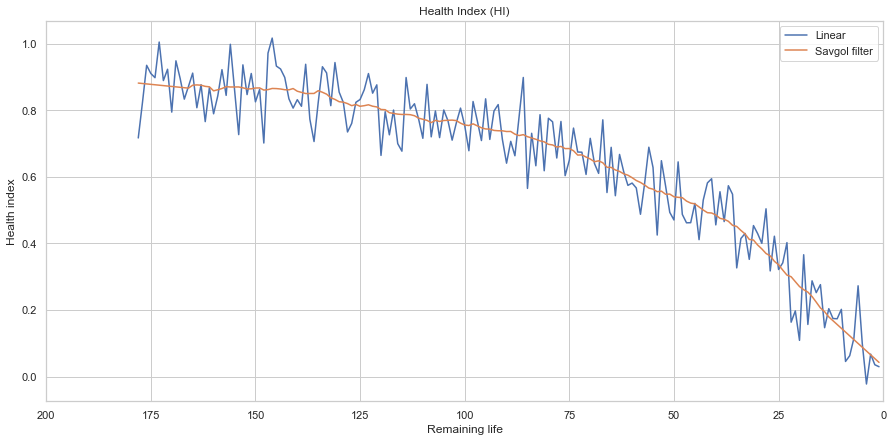

In [53]:
def health_index_of_engine(dataframe, engine_id, model):
    engine_sensors = dataframe.loc[engine_id, ['pca1', 'pca2', 'pca3']]
    engine_rul     = dataframe.loc[engine_id, 'rul']

    # Predict the health index
    health_pred = model.predict(engine_sensors)
    
    return (engine_rul, health_pred)

x, y = health_index_of_engine(df_pca, ENGINE_ID, linear_model)

# Plot the health index
fig = plt.figure(figsize=(15,7))
plt.plot(x, y, label='Linear')
plt.plot(x, savgol_filter(y, 25, 1), label='Savgol filter')
plt.title('Health Index (HI)')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(200, 0)
plt.legend();

#### Plot health indices for all engines

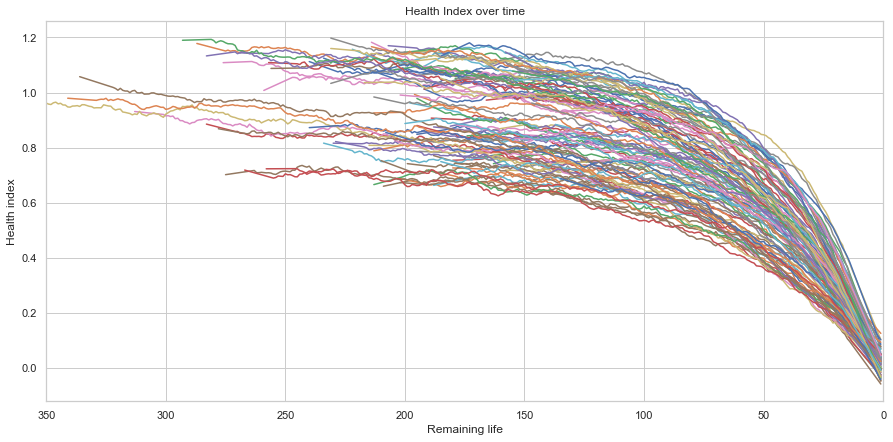

In [54]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id in df_pca.index.unique():
    x, y = health_index_of_engine(df_pca, engine_id, linear_model)

    plt.plot(x, savgol_filter(y, 25, 1), label='Savgol filter', linewidth=1.5)
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(350, 0);

### Fitting the health index curve

In [55]:
df_health_index = df_pca.copy()

df_health_index['hi_pred'] = linear_model.predict(df_health_index[['pca1', 'pca2', 'pca3']])

df_health_index.head()

,cycle,rul,pca1,pca2,pca3,hi_pred
engine_id,,,,,,
1,1.0,192.0,-2.050847,0.836783,-0.541772,0.986326
1,2.0,191.0,-1.607763,0.926619,-0.179474,0.927140
1,3.0,190.0,-2.466952,0.672027,1.057238,1.048462
1,4.0,189.0,-2.742941,-0.364782,-0.027560,1.088995
1,5.0,188.0,-1.658709,-0.710769,-0.379825,0.943971


In [56]:
def exp_func(x, a, b):
    return a * (np.exp(b * -x)-1)

x = df_health_index.loc[ENGINE_ID, 'rul']
y = savgol_filter(df_health_index.loc[ENGINE_ID, 'hi_pred'], 25, 1)

popt, _ = curve_fit(exp_func, x, y)
popt

array([-0.91841725,  0.01791806])

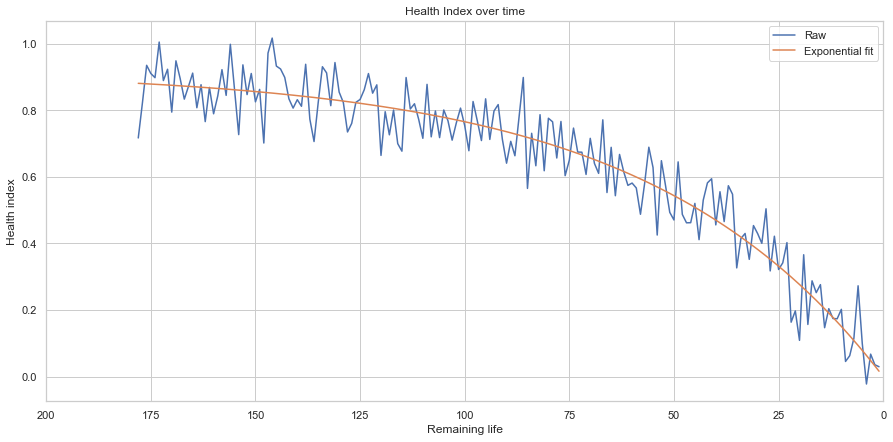

In [57]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

x, y = health_index_of_engine(df_pca, ENGINE_ID, linear_model)

plt.plot(x, y, label='Raw')
plt.plot(x, exp_func(x, *popt), label='Exponential fit')
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(200, 0)
plt.legend();

In [58]:
def find_exp_params(dataframe):
    exp_params = np.zeros((dataframe.index.nunique(), 2))
    
    # Loop through the engines
    for idx, (engine_id, engine) in enumerate(dataframe.groupby('engine_id')):
        x = engine['rul']
        y = savgol_filter(engine['hi_pred'], 25, 1)

        popt, _ = curve_fit(exp_func, x, y)
        
        exp_params[idx, :] = popt
        
    return exp_params
        
exp_params = find_exp_params(df_health_index)
exp_params[:5]

array([[-1.03800202,  0.01894311],
       [-1.20171883,  0.01272247],
       [-1.04956845,  0.02676504],
       [-0.90896104,  0.02670268],
       [-1.18395813,  0.01384315]])

#### Add the exponential fits to the dataframe

In [59]:
def get_exponential(timestep):
    return exp_func(timestep['rul'], *exp_params[timestep.name-1, :])

df_health_index['exp'] = df_health_index.apply(get_exponential, axis=1)
df_health_index.head()

,cycle,rul,pca1,pca2,pca3,hi_pred,exp
engine_id,,,,,,,
1,1.0,192.0,-2.050847,0.836783,-0.541772,0.986326,1.010672
1,2.0,191.0,-1.607763,0.926619,-0.179474,0.927140,1.010150
1,3.0,190.0,-2.466952,0.672027,1.057238,1.048462,1.009617
1,4.0,189.0,-2.742941,-0.364782,-0.027560,1.088995,1.009074
1,5.0,188.0,-1.658709,-0.710769,-0.379825,0.943971,1.008521


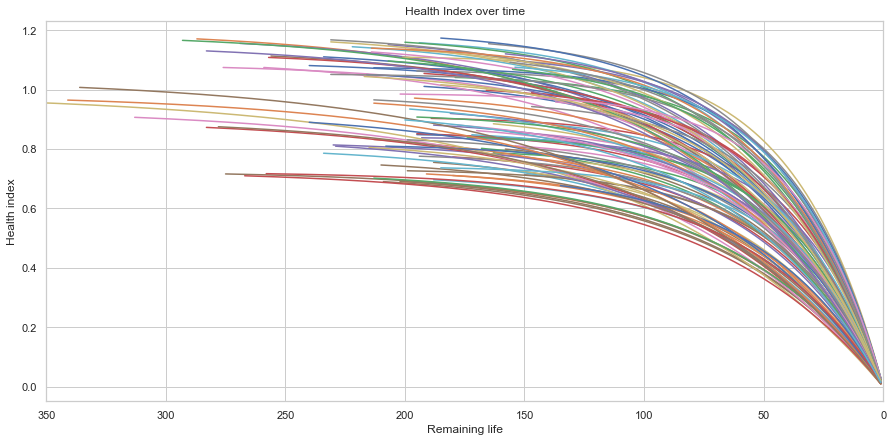

In [60]:
# Plot the health index
fig = plt.figure(figsize=(15,7))

for engine_id, engine in df_health_index.groupby('engine_id'):
    x = engine['rul']
    y = engine['exp']

    plt.plot(x, y, linewidth=1.5)
    
plt.title('Health Index over time')
plt.xlabel('Remaining life')
plt.ylabel('Health index')
plt.xlim(350, 0);

<br><br><br><br><br><br>
# 2. K-fold and final prediction
Here we transformed the code above into multiple functions, applied cross-validation (kfold = 5) and made our final predictions on the DataSchedule file.

## Functions

In [2]:
def prepare_k_fold_train_validation_set(k_folds, path = '../data/DataTrain.txt'):
    """
    This function creates k_folds of train and validation sets.
    
    We use a dictionary to store for each fold two dataframes, one dataframe 
    contains the training set and the other one the validation set.
    """
    
    df = load_dataset(path)
    df = df.set_index('engine_id')
    
    # Based on the analysing the slopes we found that the following sensors had
    # showed a trend and had the highest average slope. We focus on the sensors 
    # with higher slopes because this makes it easier to distinguish the different RULs.
    df = df[['cycle', 's4', 's3', 's17', 's7', 's12', 's2']]
    df.loc[:, 'rul'] = get_ruls(df)
    
    # Calculate percentage validation set
    unique_engine_ids = df.index.unique()
    
    # Create k_folds 
    created_k_folds = {}
    begin_index = 0
    length_fold = len(df.index.unique()) // k_folds
    
    for fold in range(0, k_folds):
        end_index = begin_index + length_fold
        get_slice = df.index.unique()[begin_index : end_index]
        
        # Extract rows
        df_training   = df[~df.index.isin(get_slice)]
        df_validation = df.loc[get_slice]
        
        # Apply scaler
        scaler = StandardScaler()
        df_training.iloc[:, 1:-1]       = scaler.fit_transform(df_training.iloc[:, 1:-1])
        df_validation.iloc[:, 1:-1]  = scaler.transform(df_validation.iloc[:, 1:-1])
        
        created_k_folds[fold] = {'training'   : df_training, 
                                 'validation' : df_validation}
        
        begin_index += length_fold
        
    # Return the k_folds as a dictionary
    return created_k_folds

In [3]:
def extract_part_validation_data(dataframe_validation, create_amount_of_random_numbers = 6, distance_of_max_length = 0, print_differences = True):
    """
    This function takes as input the df_validation and creates for each engine id
    random amount of numbers (create_amount_of_random_numbers). Then it sorts 
    those numbers and takes the lowest and biggest number (e.g. 4 and 142). It
    uses those numbers to slice a random part.
    
    We also can add the parameter 'distance_of_max_length'. This parameter allows
    us to for example set a limit of -50 of the maximum length of an engine id. If
    the engine_id has e.g. length 230 (where the RUL is 0), we can set the limit to
    finding random number between 0 and 180 (instead of 230).
    """
    
    # Extract all the unique engine ids and their maximum length in the original dataframe
    unique_engine_ids = dataframe_validation.index.unique()
    amount_of_ruls    = {engine_id : dataframe_validation[dataframe_validation.index == engine_id]['cycle'].max()
                         for engine_id in unique_engine_ids}
    
    
    # Loop over all engine ids and their length in the original dataframe_validation
    if print_differences == True:
        print('The validation dataframe includes the following engine ids: {}.\n'.format(list(unique_engine_ids)))
        print('We sliced the validation dataframe into the following slices: \n')
    new_df = pd.DataFrame()
    
    for engine_id, max_length in amount_of_ruls.items():
        random_numbers = np.random.randint(0, (max_length - 1 - distance_of_max_length), create_amount_of_random_numbers)
        random_numbers_sorted = np.sort(random_numbers, axis=None)
        
        if print_differences == True:
            print('Engine Id {} filtered on index : {}.'.format(engine_id, [random_numbers_sorted[0], random_numbers_sorted[-1]]))
            print('This slice has a length of {}.'.format(random_numbers_sorted[-1] - random_numbers_sorted[0]))
            print('The original total length of the engine id was {}.'.format(amount_of_ruls[engine_id]))
            print('------------------------------------------------\n')

        df_filtered = dataframe_validation[dataframe_validation.index == engine_id]
        df_filtered = df_filtered.iloc[random_numbers_sorted[0] : random_numbers_sorted[-1]]
        
        new_df = new_df.append(df_filtered)
        
    return new_df

In [4]:
def create_multiple_slices_of_validation_dataframe(validation_dataframe, total_amount = 5):
    """
    This function takes 'total_amount' of 'random slices' of the validation_dataframe. 
    This allows us to make the validation set bigger. 
    
    We for example take (total_amount =) 5 'random slices'. When the validation_dataframe
    has e.g. 20 engines. We take 5 * 20 'random slices', leaving us with 100 engine ids.
    """

    def change_indexes_of_dataframe(dataframe, start_from = 0):
        """
        This function resets the indexes.
        """
        # Extract current indexes
        indexes   = dataframe.index.unique()
        
        # Make a dictionary with ({old_index : new_index, ...})
        new_names = dict(zip(indexes, range(start_from, start_from + len(indexes))))    
    
        # Rename the indexes.
        dataframe_renamed_indexes = dataframe.rename(index = new_names)

        return dataframe_renamed_indexes
    
    final_dataframe = pd.DataFrame()
    current_indexes = 0
    
    # Here we create X 'total_amount' of random slices on the validation set.
    for amount in range(0, total_amount):
        # Here we change the indexes of a randomly created validation set. E.g. when the validation
        # set had engine ids [20, 21, .., 28, 29, 30] we change it to indexes/engineids [0, 1, ...8, 9, 10].
        sliced_validation_dataframe = extract_part_validation_data(validation_dataframe, create_amount_of_random_numbers = 6, print_differences=False)
        sliced_validation_dataframe = change_indexes_of_dataframe(sliced_validation_dataframe, current_indexes)
        
        # Change current_indexes to a new number.
        current_indexes = sliced_validation_dataframe.index.unique()[-1] + 1
        
        final_dataframe = final_dataframe.append(sliced_validation_dataframe)
        
    return final_dataframe

In [5]:
def get_ruls(dataframe):
    """
    Get the ruls of the engines.
    """
    
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = (dataframe['max_cycle'] - dataframe['cycle'] + 1).values
    
    return ruls

In [6]:
def slopes_all_engine(training_dataframe):
    """
    Get the sensor slopes of all engines.
    """
    
    def get_training_data(dataframe, engine_id, sensor_cols):
        # X data
        X = dataframe.loc[engine_id, 'rul'].values
        X = X.reshape(-1, 1)

        # y data
        y = dataframe.loc[engine_id, sensor_cols].values

        return (X, y)
    
    def slopes_of_engine(X, y):
        """
        Fit a linear model on the sensor values of one engine.
        """
        # Create a linear model
        linear_model = LinearRegression()

        # Fit the model
        linear_model.fit(X, y)

        # Get slopes
        slopes = linear_model.coef_[:,0]

        return slopes
    
    # Loop over all the engines and calculate the slopes.
    engine_slopes = {}
    sensor_cols = training_dataframe.columns[1: -1].tolist()
    
    for engine_id in training_dataframe.index.unique():
        X, y = get_training_data(training_dataframe, engine_id, sensor_cols)
        slopes = slopes_of_engine(X, y)
        
        engine_slopes[engine_id] = slopes
        
    df_engine_slopes = pd.DataFrame(engine_slopes).T
    
    # Change column names
    df_engine_slopes.columns = sensor_cols
    df_engine_slopes.index.name = 'engine_id'

    return df_engine_slopes

In [7]:
def perform_pca(dataframe_with_engine_slopes, dataframe_training, dataframe_validation, 
                n_components = 3, keep_rul_in_validation = True):
    """
    Here we will perform the PCA on the training and validation set.
    """
    
    # Fit the PCA on the engine slopes to reduce the dimensionality.
    pca = PCA(n_components=n_components)
    pca.fit(dataframe_with_engine_slopes)
        
    # Apply PCA on the dataframes    
    matrix_training = np.column_stack([dataframe_training[['cycle', 'rul']].values, pca.transform(dataframe_training.iloc[:, 1:-1])])   
    df_pca_training = pd.DataFrame(matrix_training, index=dataframe_training.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])
        
    if keep_rul_in_validation == True:
        matrix_validation  = np.column_stack([dataframe_validation[['cycle', 'rul']].values, pca.transform(dataframe_validation.iloc[:, 1:-1])])
        df_pca_validation  = pd.DataFrame(matrix_validation, index=dataframe_validation.index, columns=['cycle', 'rul', 'pca1', 'pca2', 'pca3'])
    
    # If we make predictions, we obviously don't have the 'rul' column. Therefor, we should pass 
    # the parameters keep_rul_in_validation = False to end up here.
    else: 
        matrix_validation  = np.column_stack([dataframe_validation[['cycle']].values, pca.transform(dataframe_validation.iloc[:, 1:])])
        df_pca_validation  = pd.DataFrame(matrix_validation, index=dataframe_validation.index, columns=['cycle', 'pca1', 'pca2', 'pca3'])

    return df_pca_training, df_pca_validation

In [8]:
def train_health_indictor_model(dataframe_training_with_pca_values, high_rul = 250, low_rul = 5):
    """
    This function applies sensor fusing to the training data and returns a
    trained model to make health indicator predictions.
    """
    
    # Extract ruls
    ruls     = dataframe_training_with_pca_values['rul'].values
    
    # Extract rows
    idx_high_health = [ruls > high_rul][0]
    idx_low_health  = [ruls <= low_rul][0]
    
    # PCA to perform sensor fusing on
    high_health_data = dataframe_training_with_pca_values.loc[idx_high_health, ['pca1', 'pca2', 'pca3']]
    low_health_data  = dataframe_training_with_pca_values.loc[idx_low_health, ['pca1', 'pca2', 'pca3']]
    
    # concatenate high HI and Low HI data
    X_health = np.concatenate((high_health_data, low_health_data),axis=0)

    # target for the fused signal [ just 0 or 1 for failed ans healthy]
    y_one = np.ones(high_health_data.shape[0])
    y_zero = np.zeros(low_health_data.shape[0])

    # concatenate high HI and Low HI target
    y_health = np.concatenate((y_one, y_zero),axis=0)
    
    # Linear regression
    linear_model = LinearRegression()
    linear_model.fit(X_health, y_health)
    
    return linear_model

In [9]:
def add_exponential_fits(dataframe_with_health_index):
    """
    This function fits an exponential model.
    """
    
    def exp_func(x, a, b):
        return a * (np.exp(b * -x)-1)

    def find_exp_params(dataframe):
        exp_params = np.zeros((dataframe.index.nunique(), 2))

        # Loop through the engines
        for idx, (engine_id, engine) in enumerate(dataframe.groupby('engine_id')):
            x = engine['rul']
            y = savgol_filter(engine['hi_pred'], 25, 1)

            popt, _ = curve_fit(exp_func, x, y)

            exp_params[idx, :] = popt

        return exp_params

    def get_exponential(timestep, row):
        return exp_func(timestep['rul'], *exp_params[row, :])

    exp_params = find_exp_params(dataframe_with_health_index)

    dataframe_with_health_index['exp'] = 0

    for index, engine_id in enumerate(dataframe_with_health_index.index.unique()):
        indexes = dataframe_with_health_index[dataframe_with_health_index.index == engine_id].index
        dataframe_with_health_index.loc[indexes, 'exp'] = dataframe_with_health_index.loc[indexes].apply(lambda x: get_exponential(x, index), axis =1)
    
    return dataframe_with_health_index

In [10]:
def predict_rul_based_on_weighted_ssd(list_with_ssd_and_rul, extract_best_x = 5):
    """
    This function makes based on a nested list [(ssd1, rul1), ... , (ssdN, rulN)]
    a weighted prediction based on the ssd.
    """
    
    # Create a dataframe of the nested list
    df_ssd_and_rul = pd.DataFrame(list_with_ssd_and_rul, columns=['ssd', 'rul'])
        
    # Sort the dataframe based on the ssd and extract top X (extract_best_x)
    df_ssd_and_rul = df_ssd_and_rul.sort_values('ssd').iloc[ : extract_best_x]
    
    # Add percentage ssd of total
    sum_ssd = sum(1 / df_ssd_and_rul['ssd'].values)   
    df_ssd_and_rul['percentage_of_total'] = (1 / df_ssd_and_rul['ssd']) / sum_ssd
    
    # Make weighted predictions
    weighted_prediction = sum(df_ssd_and_rul['rul'] * df_ssd_and_rul['percentage_of_total'])
    
    # Return prediction
    return weighted_prediction

In [11]:
def find_for_engineid_lowest_loss(dataframe_training, 
                                  dataframe_validation_engineid,
                                  make_prediction_only = False,
                                  print_differences = True):
    """
    The input of the function to find the lowest losses and make weighted prediction includes:
    - dataframe_training with where we fitted an exponential model on the health indicators.
    - dataframe_validation_engineid: this is 1 engine id with all its cycles.
    
    We make a weighted prediction by taking the health indicator of dataframe_validation_engineid
    and comparing this with the exponential values of each engine id in dataframe_training. We e.g.
    start with engine_id 1 and shift over each row to find the lowest loss in engine_id 1. 
    
    The rows where the loss is the lowest, we will predict the RUL. Because we do this for 
    each engine id in the dataframe_training we will obtain multiple losses and predicted RULs.
    Therefore, we will use a weighted prediction. We take the top 5 lowest losses to make
    a weighted prediction.
    """
    
    results = list()
    length    = len(dataframe_validation_engineid)
    
    # We will look in each engine (of dataframe_training) for the lowest loss.
    # When we find it, we will store it with the predicted RUL. This allows us 
    # to make predictions taking into account all the engineids.
    for engine_id in dataframe_training.index.unique():
        filtered_df = dataframe_training[dataframe_training.index == engine_id]
        best_loss   = np.inf
        best_train_slice = list()
        
        # Loop over each array in the filtered dataframe and try to find the 
        # best 'exp' where the loss is the lowest.
        for row_index in range(0, len(filtered_df) - length):
            train_slice             = filtered_df.iloc[row_index : (row_index+length)]
            train_health_index      = train_slice['exp'].values
            validation_health_index = dataframe_validation_engineid['hi_pred'].values

            loss = np.sum((train_health_index - validation_health_index) ** 2)

            if loss < best_loss:
                best_loss        = loss
                best_train_slice = train_slice
                
        # If we couldn't find any good fit on the 'exp' in this engine id, skip the
        # appending to the results.
        if best_loss == np.inf:
            continue
            
        # Add the result (loss and the RUL)
        results.append([best_loss, int(best_train_slice.iloc[-1]['rul'])])
        
    # Make a weighted prediction based on the nested list
    weighted_prediction = int(predict_rul_based_on_weighted_ssd(results))
    
    if make_prediction_only == False:
        best_rul_difference = abs(int(dataframe_validation_engineid.iloc[-1]['rul']) - weighted_prediction)
        
        if print_differences == True:
            print('Best loss:      ', best_loss)
            print('Train RUL:      ', int(weighted_prediction))
            print('Validation RUL: ', int(dataframe_validation_engineid.iloc[-1]['rul']))
            print('RUL difference: ', best_rul_difference)
            print('\n')    

        return weighted_prediction, int(dataframe_validation_engineid.iloc[-1]['rul'])
    
    else:
        return weighted_prediction

In [12]:
def plot_k_fold_result(cross_validation_results):
    """
    This function plots the k fold results.
    """
    # Plot mean absolute errors
    mae      = [fold['mean_absolute_error'] for foldnr, fold in cross_validation_results.items()]
    foldsnrs = ['Fold {}'.format(foldnr + 1) for foldnr, fold in cross_validation_results.items()]
        
    fig, ax = plt.subplots()
    ax.bar(foldsnrs, mae)
    ax.set_xlabel('Folds')
    ax.set_ylabel('Mean absolute errors')
    ax.set_title('Mean absolute error per fold')
    plt.show();
    
    # Plot cross validation results
    for foldnr, fold in cross_validation_results.items():
        validation_pred = fold['validation_pred']
        y_validation    = fold['y_validation']
    
        # Plot results
        fig, ax = plt.subplots()
        ax.scatter(validation_pred, y_validation, edgecolors=(0, 0, 0))
        ax.plot([min(y_validation), max(y_validation)], [min(y_validation), max(y_validation)], 'k--')
        ax.set_xlabel('Predicted RUL')
        ax.set_ylabel('Actual RUL')
        ax.set_title('K_Fold {} Predicted RUL vs Actual RUL'.format(foldnr + 1))
        plt.show();

In [13]:
def final_prediction(dataframe_training, dataframe_schedule):
    """
    This function makes a prediction on the dataframe_schedule using the
    dataframe_training.
    
    To make a prediction, we apply the following steps:
    1. Extract the relevant columns from both tables.
    2. Calculate the slopes of the dataframe_training.
    3. Apply PCA and transform both dataframe_training and dataframe_schedule.
    4. Train a linear model to predict the health indicators.
    5. Predict the health indicators (hi_pred) of both tables.
    6. Fit an exponential model on the hi_pred of dataframe_training (exp).
    7. Try to fit each engine_ids hi_pred in the dataframe_schedule on the best
       suiting 'exp'. Based on the best fit we will predict the RUL.
    """
    # Extract the relevant columns from both tables
    columns = ['cycle', 's4', 's3', 's17', 's7', 's12', 's2', 'rul']
    
    dataframe_training = dataframe_training[columns]
    dataframe_schedule = dataframe_schedule[columns[: -1]]
            
    # Calculate slopes of the dataframe_training
    dataframe_training_slopes = slopes_all_engine(dataframe_training)
    
    # Reduce dimensionalities with PCA
    dataframe_training_pca, dataframe_schedule_pca = perform_pca(dataframe_training_slopes, 
                                                                 dataframe_training, 
                                                                 dataframe_schedule, 
                                                                 keep_rul_in_validation = False)
    
    # Train linear model
    trained_model = train_health_indictor_model(dataframe_training_pca)
        
    # Predict health indicator
    dataframe_training['hi_pred'] = trained_model.predict(dataframe_training_pca[['pca1', 'pca2', 'pca3']])
    dataframe_schedule['hi_pred'] = trained_model.predict(dataframe_schedule_pca[['pca1', 'pca2', 'pca3']])
    
    # Add exponential fit
    dataframe_training = add_exponential_fits(dataframe_training)
    
    # Make predictions
    results = {}
    
    for engineid in dataframe_training.index.unique():
        results[engineid] = find_for_engineid_lowest_loss(dataframe_training, 
                                                          dataframe_schedule[dataframe_schedule.index == engineid],
                                                          make_prediction_only = True)    
        
    return results

<br><br><br><br>

## Apply cross validation to the model
Here we apply cross validation (k_folds = 5) on our model.

In [22]:
%%time

# Cross validation results
cv_results = {}

# Create k_folds of train and validation set.
k_folds = prepare_k_fold_train_validation_set(k_folds = 5)

# Loop over each fold and check results
for foldnr, fold_values in k_folds.items():    
    # Keep track of the time
    start = time.time()
    print('Started with foldnr {}.'.format(foldnr))
    
    # Extract training and validation set
    df_training   = fold_values['training']
    df_validation = fold_values['validation']
    
    # Enhance the validation set by taking random slices
    df_validation = create_multiple_slices_of_validation_dataframe(df_validation, total_amount = 20)
    
    # Extract slopes
    df_slopes = slopes_all_engine(df_training)
    
    # Reduce the dimensionalities to 3 dimensions
    df_training_pca, df_validation_pca = perform_pca(df_slopes, df_training, df_validation, keep_rul_in_validation = True)

    # Train model to predict Health Indicator
    model = train_health_indictor_model(df_training_pca)

    # Add health indicator
    df_training_pca['hi_pred']   = model.predict(df_training_pca[['pca1', 'pca2', 'pca3']])
    df_validation_pca['hi_pred'] = model.predict(df_validation_pca[['pca1', 'pca2', 'pca3']])
    
    # Add exponential fit
    df_training_with_hi_and_exp = add_exponential_fits(df_training_pca)
    
    print('Finished with exponential fits.')
    
    # Extract predicted RUL and actual RUL
    results = {}
    total_rul_diff = 0

    for engineid in df_validation_pca.index.unique():
        rul_prediction, actual_rul = find_for_engineid_lowest_loss(df_training_with_hi_and_exp, 
                                                                   df_validation_pca[df_validation_pca.index == engineid],
                                                                   print_differences = False)

        rul_difference = abs(rul_prediction - actual_rul)
        results[engineid] = {'rul_prediction' : rul_prediction,
                             'actual_rul'     : actual_rul,
                             'rul_difference' : rul_difference}

        total_rul_diff += rul_difference

    # Get MAE and predicted RUL and actual RUL
    mean_absolute_error = total_rul_diff / len(df_validation_pca.index.unique())
    
    validation_pred  = [element['rul_prediction'] for element in results.values()]
    validation_error = [element['rul_difference'] for element in results.values()]
    y_validation     = [element['actual_rul'] for element in results.values()]
    
    
    # Add the result of the fold
    cv_results[foldnr] = {'validation_pred'  : validation_pred, 
                          'validation_error' : validation_error,
                          'y_validation'     : y_validation,
                          'mean_absolute_error' : mean_absolute_error}
    
    print('Finished with foldnr {} (took {} minutes).\n\n'.format(foldnr, (time.time() - start) / 60))

Started with foldnr 0.
Finished with exponential fits.
Finished with foldnr 0 (took 20.742994304498037 minutes).


Started with foldnr 1.
Finished with exponential fits.
Finished with foldnr 1 (took 16.11907161474228 minutes).


Started with foldnr 2.
Finished with exponential fits.
Finished with foldnr 2 (took 12.208328640460968 minutes).


Started with foldnr 3.
Finished with exponential fits.
Finished with foldnr 3 (took 12.460281387964885 minutes).


Started with foldnr 4.
Finished with exponential fits.
Finished with foldnr 4 (took 16.219913681348164 minutes).


Wall time: 1h 17min 45s


In [26]:
# Save results
with open('cv_results.pkl', 'wb') as output_file:
    pickle.dump(cv_results, output_file)

In [27]:
# # Open results
# with open('cv_results.pkl', 'rb') as output:
#     cv_results_from_pickle = pickle.load(output)

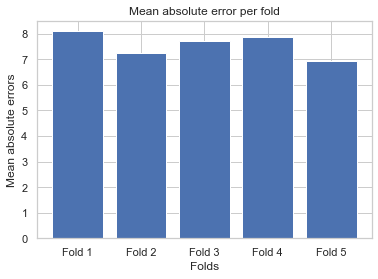

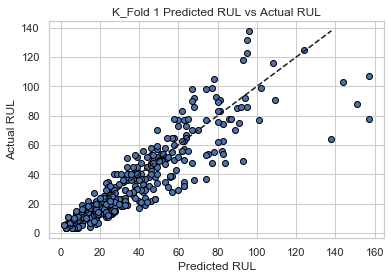

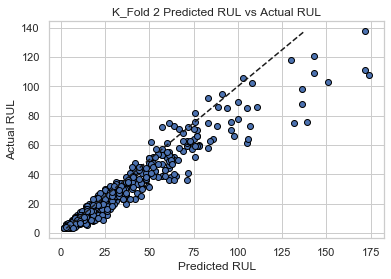

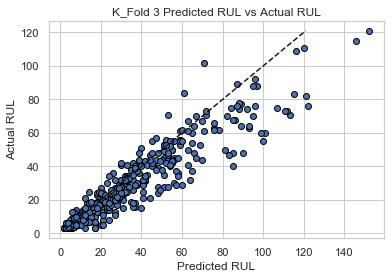

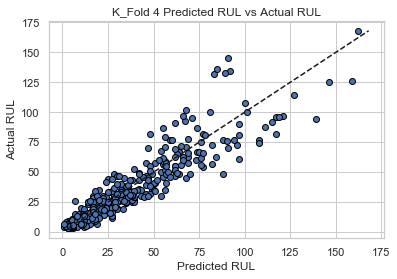

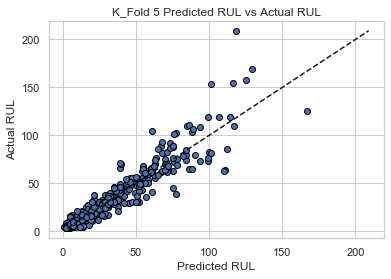

In [28]:
plot_k_fold_result(cv_results)

<br><br><br><br>

## Final prediction
Here we make predictions on the dataframe_schedule using the dataframe_training.

To make a prediction, we apply the following steps:
1. Extract the relevant columns from both tables (training and test set).
2. Calculate the slopes of the dataframe_training.
3. Apply PCA and transform both dataframe_training and dataframe_schedule.
4. Train a linear model to predict the health indicators.
5. Predict the health indicators (hi_pred) of both tables (training and test set).
6. Fit an exponential model on the hi_pred of dataframe_training (exp).
7. Try to fit each engine_ids hi_pred in the dataframe_schedule on the best suiting 'exp'. Based on the best fit we will predict the RUL.

In [59]:
%%time

# Load the training data and add the RUL
df_train               = load_dataset('../data/DataTrain.txt')
df_train               = df_train.set_index('engine_id')
df_train.loc[: ,'rul'] = get_ruls(df_train)

# Load the test set
df_schedule = load_dataset('../data/DataSchedule.txt')
df_schedule = df_schedule.set_index('engine_id')

# Make the predictions
predictions = final_prediction(df_train, df_schedule)

Wall time: 5min 19s


In [74]:
df_predictions = pd.DataFrame.from_dict(predictions, orient = 'index').rename(columns = {0: 'RUL'})
df_predictions.to_excel('predictions.xlsx')
df_predictions.head()

,RUL
1,174
2,151
3,68
4,92
5,95
